# SET TRAIN & TEST VOLUME

### build dataset for one month

In [47]:
from model_pipeline.food_material_price.core import PricePredictModelPipeline


model_pipeline = PricePredictModelPipeline(
    bucket_name="production-bobsim",
    date="201908"
)

dataset = model_pipeline.build_dataset()

model_pipeline = PricePredictModelPipeline(
    bucket_name="production-bobsim",
    date="201907"
)

dataset0 = model_pipeline.build_dataset()

2020-04-02 14:33:01:manager:<INFO> 1 files is loaded from public_data/open_data_raw_material_price/origin/csv/201908.csv in s3 'production-bobsim'
2020-04-02 14:33:02:core:<INFO> no missing value at raw material price
2020-04-02 14:33:06:manager:<INFO> data is saved to 'public_data/open_data_raw_material_price/process/csv/201908.csv' in s3 'production-bobsim'
2020-04-02 14:33:06:core:<INFO> success to process raw material price
2020-04-02 14:33:10:manager:<INFO> 1 files is loaded from public_data/open_data_raw_material_price/process/csv/201908.csv in s3 'production-bobsim'
2020-04-02 14:33:33:manager:<INFO> 1 files is loaded from public_data/open_data_terrestrial_weather/origin/csv/2014-2020.csv in s3 'production-bobsim'
2020-04-02 14:33:33:core:<INFO> Series([], dtype: int64)
2020-04-02 14:33:33:manager:<INFO> data is saved to 'public_data/open_data_terrestrial_weather/process/csv/201908.csv' in s3 'production-bobsim'
2020-04-02 14:33:33:core:<INFO> success to process
2020-04-02 14:33

In [79]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from model.elastic_net import ElasticNetModel
import matplotlib.pyplot as plt
import numpy as np
import functools

def customized_rmse(y, y_pred):
    error = y - y_pred
    def penalize(x):
        if x > 0:
            # if y > y_pred, penalize 10%
            return x * 1.1
        else:
            return x
    X = np.vectorize(penalize)(error)
    return np.sqrt(np.square(X).mean())

def split_xy(df: pd.DataFrame):
    # print(df.조사일자.drop_duplicates())
    return df.drop(columns=["당일조사가격", "조사일자"]), df["당일조사가격"]

def split_train_test(start, standard, df: pd.DataFrame):
    train = df[(start <= df.조사일자.dt.date) & (df.조사일자.dt.date < standard)]
    test = df[df.조사일자.dt.date >= standard]
    return train, test

def get_score(x, day, df):
    train, test = split_train_test(x, day, df)
    
    x_train, y_train = split_xy(train)
    x_test, y_test = split_xy(test)
    
    regr = ElasticNetModel(x_train, y_train)
    regr.fit()
    y_pred = regr.predict(x_test)
    
    metric = customized_rmse(y_test, y_pred)
    return metric

def find_train_test(i, df):
    reverse_list = df.조사일자.drop_duplicates().sort_values(ascending=False).tolist()
    standard_day = reverse_list[i]
    score_list = list(map(functools.partial(get_score, day=standard_day, df=df), reverse_list[i+1:]))
    pd.Series(score_list, index=reverse_list[i+1:]).plot()
    print("metric list for standard '{day}': {metrics}".format(day=standard_day, metrics=score_list))

    

C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 244609940.5164525, tolerance: 1272781.1259176128
  positive)
C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\An

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2750564996.146818, tolerance: 15482526.065148694
  positive)
C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)


metric list for standard '2019-08-21 00:00:00': [563.0498043068036, 552.2481473360086, 557.8060579595469, 551.819918673687, 554.075043975355, 555.1108053109622, 557.452660737978, 559.9896424472646, 561.9801992960564, 563.1040528709726, 565.0619734451019, 566.4337455336597, 568.4727293334064]


C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2960803954.906143, tolerance: 16733436.770004129
  positive)


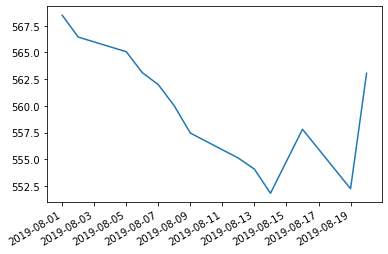

In [80]:
find_train_test(7, dataset)

C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 201225458.62927938, tolerance: 1298976.1709992436
  positive)
C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\A

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2403577630.2876377, tolerance: 15179991.10094371
  positive)
C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2593518714.5313983, tolerance: 16389020.

metric list for standard '2019-07-22 00:00:00': [530.4489944312139, 534.5740893410465, 531.1388195586097, 528.3788507824905, 528.6481662314194, 527.0944548312352, 527.3880107545536, 529.0514500451569, 527.0443382537286, 527.1974460591923, 526.8791862324712, 527.5122660728304, 528.2095855042892, 529.9861289653471]


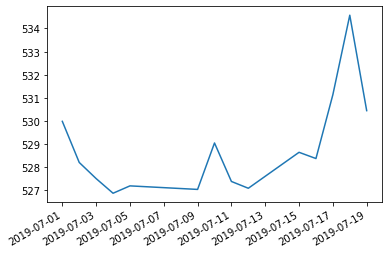

In [81]:
find_train_test(7, dataset0)

C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 217938560.8507143, tolerance: 1306661.5176960495
  positive)
C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\An

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2633399649.3455753, tolerance: 15677201.516202949
  positive)
C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2842734143.8443837, tolerance: 17004751

metric list for standard '2019-07-31 00:00:00': [501.07657975779733, 502.00242134317244, 502.7893311597004, 504.49948374867984, 506.6637112656272, 508.63543504263293, 511.0359822953797, 512.5598384395508, 514.2472949203371, 514.5673754360247, 514.4559165926792, 514.3082544990726, 513.8777255007105, 514.2587589638706, 514.0077179105859, 514.3827512587231, 515.4323958066503, 516.0725297297741, 516.3724839296341, 516.9048963656521, 517.3565795393835]


C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 431567211.5181958, tolerance: 2573994.40461255
  positive)
C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\Anac

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2809727200.897977, tolerance: 16916487.357911974
  positive)
C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM

metric list for standard '2019-07-30 00:00:00': [639.1877950905288, 508.43178523329726, 510.0463693521124, 513.2143099870498, 514.6050536933628, 516.4461856646287, 517.9488076518809, 519.7205771804369, 519.723090696427, 519.3863114061144, 519.1065717158397, 518.7788471674318, 518.7177977529717, 518.3440213292422, 518.5297325176491, 519.1571332558635, 519.6475805284181, 519.9173980880594, 520.3820080169772, 520.8833880198629]


C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 423396159.88377684, tolerance: 2534188.02315116
  positive)
C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\Ana

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2779438147.4979415, tolerance: 16882666.337387655
  positive)
C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSI

metric list for standard '2019-07-29 00:00:00': [508.4219778286114, 1152.1993648150174, 518.9368271596818, 514.2333924217686, 515.3271269962275, 517.5663356811609, 518.3019393055696, 518.024601994096, 517.3946027243688, 517.4841296947828, 516.6128798766335, 516.679667157682, 516.4206092709047, 516.5992156980388, 516.9474166181269, 517.4478956820553, 517.7961892290881, 518.2816458631389, 518.9766208011615]


C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3899701462.5002966, tolerance: 23952972.640056305
  positive)


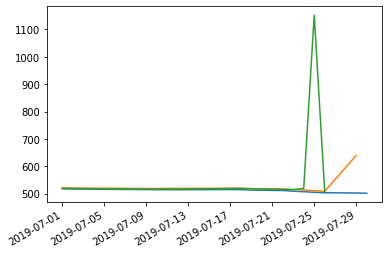

In [86]:
for i in range(0,3):
    find_train_test(i, dataset0)

C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 256040202.70686093, tolerance: 1288273.0429313336
  positive)
C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\A

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2881502418.1204853, tolerance: 15481058.49176562
  positive)
C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM

metric list for standard '2019-08-27 00:00:00': [537.6355537398538, 530.9234377830307, 531.411587362321, 532.6865269132487, 533.0153903796786, 535.4181666522381, 536.0870827520293, 536.5539576674107, 537.4328406436526, 537.0778348032586, 538.7846429042419, 541.6587077102889, 543.5218182038296, 543.5286406697275, 544.536845384323, 545.5538587568691, 547.0477555190985]


C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 516826884.94812334, tolerance: 2628899.1055600815
  positive)
C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\A

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3119526642.900009, tolerance: 16817529.418055665
  positive)
C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM

metric list for standard '2019-08-26 00:00:00': [61730.68144139059, 535.8914125865269, 537.2793062286522, 538.0279929915835, 539.108858253673, 539.8912962171089, 550.6422717607704, 550.2816897424017, 548.4547309719356, 550.3639788998469, 558.1165199836748, 560.8382024232403, 557.5837045719729, 559.0809850207379, 560.3856130304773, 560.1483739860519]


C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 525936434.2358868, tolerance: 2595154.0978458985
  positive)
C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\An

C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3311926917.6990824, tolerance: 18077692.65027608
  positive)
C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\An

metric list for standard '2019-08-23 00:00:00': [536.3199835859901, 771.8137293455849, 605.227015140526, 545.7841635750032, 547.1423059793382, 546.8243775375715, 548.3150210939586, 552.0464924798865, 553.5965000498778, 554.7423774210381, 557.5312542469064, 557.066991411849, 558.554879597511, 559.7206336860762, 561.6049150454404]


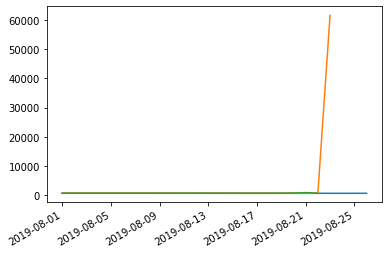

In [83]:
for i in range(3,6):
    find_train_test(i, dataset)

C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 205830268.05124688, tolerance: 1308240.5498435043
  positive)
C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\A

metric list for standard '2019-08-16 00:00:00': [560.8396836654098, 560.8397349988737, 562.9837302306915, 565.3864574701407, 572.3706229244666, 578.3341363520602, 578.8360035604827, 574.8177176070484, 575.0327023609042, 574.9836970861926]


C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 405441459.9898506, tolerance: 2608015.4767802097
  positive)
C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\An

metric list for standard '2019-08-14 00:00:00': [587.105421526497, 560.176963311373, 562.7191030232939, 569.0306920829141, 574.8977646797991, 575.8009833990676, 572.3154017499465, 573.1494490508406, 574.080543478038]


C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 444950271.3659163, tolerance: 2626953.919864031
  positive)
C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\Ana

metric list for standard '2019-08-13 00:00:00': [559.2789314395409, 558.4462641813857, 568.293961544275, 573.1300312534105, 575.1256498729323, 567.7612732621884, 568.1539774118974, 569.6901285968179]


C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 232430358.6659936, tolerance: 1321402.0071077596
  positive)
C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\An

metric list for standard '2019-08-12 00:00:00': [581.7903257943151, 565.861612179352, 567.8210266943126, 572.0922477161768, 579.6212412689013, 569.2912434187227, 566.0689784755375]


C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 227488522.65779743, tolerance: 1279984.1328601572
  positive)
C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSI

metric list for standard '2019-08-09 00:00:00': [591.6337628210282, 568.4752104052052, 572.5702650098881, 572.5685033428649, 568.5042811080193, 566.314808944479]


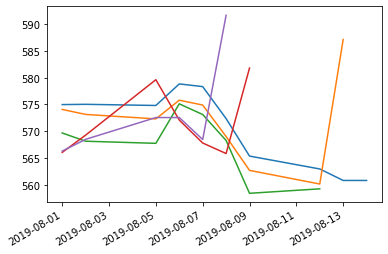

In [84]:
for i in range(10,15):
    find_train_test(i, dataset)

C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 236085723.3177243, tolerance: 1304937.3439763281
  positive)
C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\An

metric list for standard '2019-08-08 00:00:00': [569.9720099804381, 569.1663441865775, 565.4766054401747, 566.4136087008247, 567.9479227304441]


C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225687144.96739066, tolerance: 1319798.662989795
  positive)
C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM

metric list for standard '2019-08-07 00:00:00': [564.9268921216349, 563.4561729380172, 566.6500699441872, 566.6292855104487]


C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 420159915.2899002, tolerance: 2579568.6138827708
  positive)
C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\An

metric list for standard '2019-08-06 00:00:00': [593.5928339635733, 755.5628873000347, 588.315309344394]


C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209029473.43376657, tolerance: 1301057.6157194125
  positive)
C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSI

metric list for standard '2019-08-05 00:00:00': [576.9716612848625, 588.8109256533263]


C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 192924357.03028852, tolerance: 1250703.935183338
  positive)


metric list for standard '2019-08-02 00:00:00': [653.3307459592595]


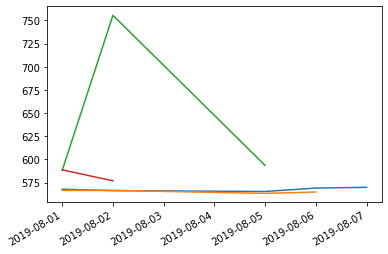

In [85]:
for i in range(15,20):
    find_train_test(i, dataset)

metric list for standard '2019-08-02 00:00:00': [468.4488626185235]


C:\BOBSIM\production-bobsim-python\src\main\python\model\elastic_net.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(self.x_train, self.y_train)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 192924357.03028852, tolerance: 1250703.935183338
  positive)


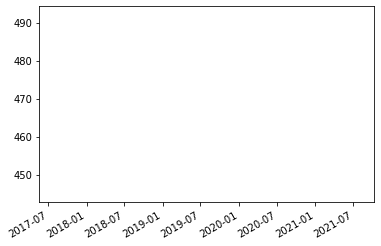

In [46]:
find_train_test(19, dataset)

In [4]:
from sklearn.linear_model import ElasticNet

en = ElasticNet(alpha=0, l1_ratio=0.0, max_iter=5)
en.fit(train_x, train_y)
pred = en.predict(test_x)
model_pipeline.customized_rmse(test_y, pred)

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\ipykernel_launcher.py:4: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  after removing the cwd from sys.path.
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2960803954.906143, tolerance: 16733436.770004129
  positive)


568.4727293334064